# About the Project
In this assignment, Kaggle competition called [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started) is used to try GAN learned in the week5 lecture.

***
## Problem Description
In this competition, 300 Monet paintings for style traing and 7028 photos for style conversion are provided. We are requested to generate style-transfered jpeng image.

Evaluation is done based on "MiFID (Memorization-informed Frechet Inception Distance)". This is used as the standard evaluation methods of GANs. This metrics feeds both generated images and real images to the Inception network and then extract intermediate results to calculate FID score between those twos.

$$\mathrm{FID} = ||\mu_r - \mu_g||^2 + \mathrm{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}$$

where $\mathrm{T_r}$ sums up all the diagonal elements of the matrix. FID is calculated by computing the Frechet distance between two Gaussians fitted to feature  representations of the Inception network.

MiFiD is the modified version of this metrics. You can see the overview of competition website to see more details.

In [1]:
import os
import glob
import tensorflow as tf
import numpy as np
import glob
import cv2
import io
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.10.0'

***
## EDA
### Visualize Example Image
As the data is provided as binary format, I firstly tried to visualize the image.  
tfrec concatates plural images together, and we can see only 5 tfrec files whereas the dataset description clamis there are 300 monet images.

In [3]:
monet_path = os.path.join('gan-getting-started/', 'monet_tfrec')
photo_path = os.path.join('gan-getting-started/', 'photo_tfrec')

### Parse tfrec Image Provided
In order to parse tfrec format image, we need to specify the data format and pass it with the binary data to `tf.io.parse_single_example()` function. This can be a parser function for the specified binary image.    
Concatenated data will be loaded by `tf.data.TFRecordDataset()` and then the output is mapped to the parser.

In [4]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_protobuf):
    # Parse the input `tf.train.Example` proto using the feature description.
    parsed_example = tf.io.parse_single_example(example_protobuf, feature_description)

    # Decode the image and reshape
    image = tf.io.decode_jpeg(parsed_example['image'])
    image = tf.image.resize(image, [256, 256])  # Resize to desired size
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

In [5]:
monet_image_dataset = tf.data.Dataset.list_files(monet_path + '/*.tfrec')
monet_image_dataset = monet_image_dataset.interleave(tf.data.TFRecordDataset, cycle_length=4)
monet_image_dataset = monet_image_dataset.map(_parse_function)

photo_image_dataset = tf.data.Dataset.list_files(photo_path + '/*.tfrec')
photo_image_dataset = photo_image_dataset.interleave(tf.data.TFRecordDataset, cycle_length=4)
photo_image_dataset = photo_image_dataset.map(_parse_function)

#### Example Monet Image

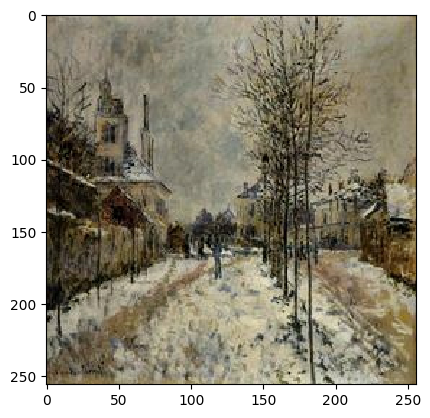

In [6]:
for e in monet_image_dataset.take(1):
    # denormalize to [0, 1] from [-1, 1]
    image = (e.numpy() + 1) / 2
plt.imshow(image, interpolation='nearest')
plt.show()

#### Example Photo

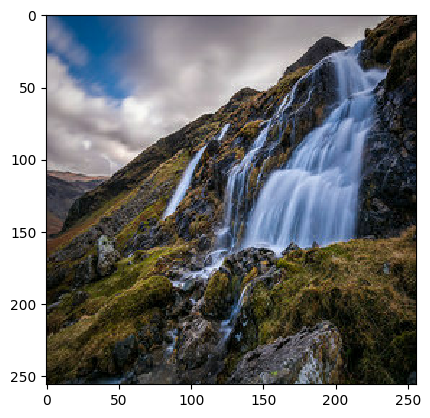

In [7]:
for e in photo_image_dataset.take(1):
    # denormalize to [0, 1] from [-1, 1]
    image = (e.numpy() + 1) / 2
plt.imshow(image, interpolation='nearest')
plt.show()

### Shuffle dataset to avoid unintended biases
I didn't checked all data, but let's shuffle to avoid unintended biases (e.g. if the training image is sorted by date, it may affects to the training weights)

In [8]:
BUFFER_SIZE = 400
BATCH_SIZE = 32
monet_image_dataset = monet_image_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
photo_image_dataset = photo_image_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

monet_image_dataset, photo_image_dataset

(<PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None)>,
 <PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None)>)

***
## Model For Training
### Cycle GAN
Cycle GAN is some kind of GAN network which utilize pair of Generator and Disciminator, to keep consistency between generated image and source image. By considering error derived from cyclic transformed image, CycleGAN enabled style transfer with relatively few number of training samples.

![CycleGAN Concept](CGAN1.jpg "CycleGAN Concept")
***
![CycleGAN Concept](CGAN2.jpg "CycleGAN Concept")

In [9]:
def make_generator_model():
    """ generator model is defined using u-net encoder-decoder architecture
    """
    # Encoder
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down1 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    down1 = tf.keras.layers.LeakyReLU()(down1)
    down2 = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = tf.keras.layers.LeakyReLU()(down2)
    down2 = tf.keras.layers.BatchNormalization()(down2)
    down3 = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    down3 = tf.keras.layers.LeakyReLU()(down3)
    down3 = tf.keras.layers.BatchNormalization()(down3)
    down4 = tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same')(down3)
    down4 = tf.keras.layers.LeakyReLU()(down4)
    down4 = tf.keras.layers.BatchNormalization()(down4)
  
    # Decoder
    up1 = tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=2, padding='same')(down4)
    up1 = tf.keras.layers.LeakyReLU()(up1)
    up1 = tf.keras.layers.BatchNormalization()(up1)
    up2 = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')(up1)
    up2 = tf.keras.layers.LeakyReLU()(up2)
    up2 = tf.keras.layers.BatchNormalization()(up2)
    up3 = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(up2)
    up3 = tf.keras.layers.LeakyReLU()(up3)
    up3 = tf.keras.layers.BatchNormalization()(up3)
    outputs = tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(up3)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [10]:
def make_discriminator_model():
    """ discriminator model is defined. Input will be the same as the orignal image and output is binary value.
    """
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    d1 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    d1 = tf.keras.layers.LeakyReLU()(d1)
    d2 = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(d1)
    d2 = tf.keras.layers.LeakyReLU()(d2)
    d2 = tf.keras.layers.BatchNormalization()(d2)
    d3 = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(d2)
    d3 = tf.keras.layers.LeakyReLU()(d3)
    d3 = tf.keras.layers.BatchNormalization()(d3)
    d4 = tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same', activation='relu')(d3)
    d4 = tf.keras.layers.LeakyReLU()(d4)
    d4 = tf.keras.layers.BatchNormalization()(d4)
    
    outputs = tf.keras.layers.Conv2D(1, (4, 4), padding='same')(d4)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

### Define Loss function
As to discriminator, we need to consider error for both real data (expected output is one) and generated data (expected output is zero).  
At the same time, generator want to be treated as "real" so that discriminator cannot differentiate with real data. So the objective function takes opposite value (expected output is one)

In [11]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real, generated):
    """ calculate loss function assuming discriminator's target is to properly detect real and generated data
    """
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [13]:
def generator_loss(generated):
    """ calculate loss function assuming generator's target is to fake discriminator (want to be treated as real)
    """
    return loss_object(tf.ones_like(generated), generated)

In [14]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA=10):
    """ Inverse transformed output against transformed image should be returned back to original image.
    This loss function calculates such error
    """
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

### Apply Optimizer
In this report, I'd like to use two generator and two discriminator

In [15]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.3)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.3)

In [16]:
generator_g = make_generator_model()
generator_f = make_generator_model()
discriminator_x = make_discriminator_model()
discriminator_y = make_discriminator_model()

### Describe Model
Both generators and discriminators used here is relatively simple.

In [17]:
generator_g.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                             

In [18]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                           

In [19]:
@tf.function
def train_step(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y, 
               generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer, discriminator_y_optimizer):
    """
    real_x: photo to be transformed
    real_y: monet image
    generator_g: generator to make monet-image from given photo
    generator_f: generator to make photo-like-image from fake-monet-image
    discriminator_x: discriminator to detect if given input is photo or not 
    discriminator_y: discriminator to detect if given input is monet or not
    generator_g_optimizer: Adam optimizer for generator_g
    generator_f_optimizer: Adam optimizer for generator_f
    discriminator_x_optimizer: Adam optimizer for discriminator_x
    discriminator_y_optimizer: Adam optimizer for discriminator_y
    """
    with tf.GradientTape(persistent=True) as tape:
        # Generate monet-like image from given photo
        fake_y = generator_g(real_x, training=True)
        # inversion (invert from monet-like image to photo-like image)
        cycled_x = generator_f(fake_y, training=True)

        # Generate photo-like image from given monet-image
        fake_x = generator_f(real_y, training=True)
        # inversion (invert from photo-like image to monet-like image)
        cycled_y = generator_g(fake_x, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True) # is given image is really a photo?
        disc_real_y = discriminator_y(real_y, training=True) # is given image is really a monet?
        disc_fake_x = discriminator_x(fake_x, training=True) # is given generated image is really a photo?
        disc_fake_y = discriminator_y(fake_y, training=True) # is given generated image is really a monet?

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y) # if monet-like imaage deceived monet image discriminator?
        gen_f_loss = generator_loss(disc_fake_x) # if photo-like imaage deceived photo image discriminator?

        # Total cycle consistency loss
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients and apply them
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

# Take a sample of photos for visualization
sample_photos = next(iter(photo_image_dataset))
SAMPLES_FOR_VISUALIZE = 4  # Number of samples to visualize


In [20]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(12, 12))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2.0)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Do Fitting
Hwew, generator output is visualized for each 5 epoch.

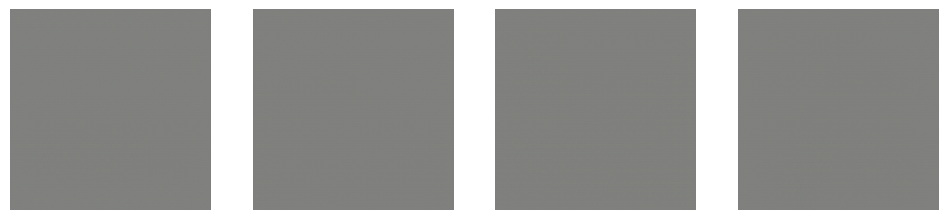

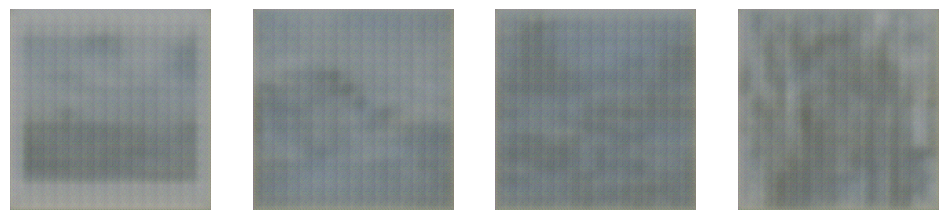

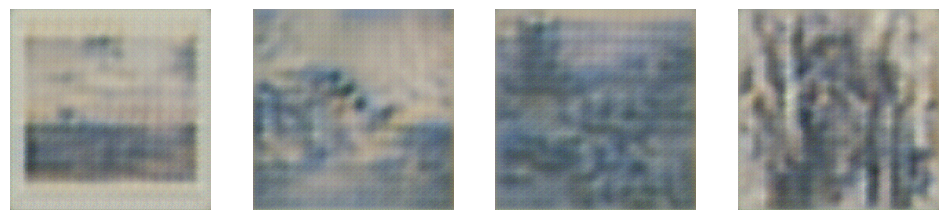

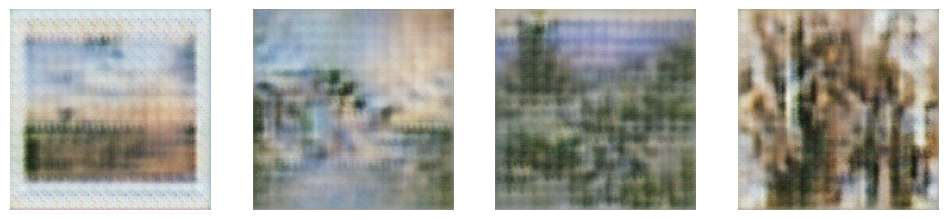

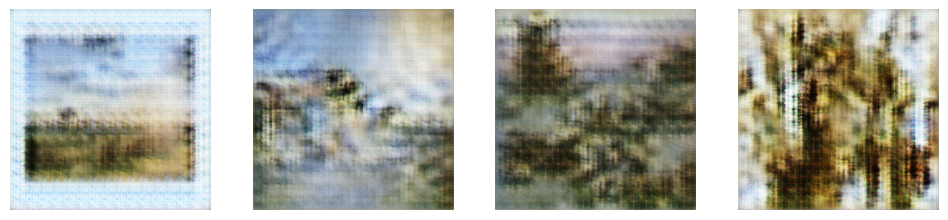

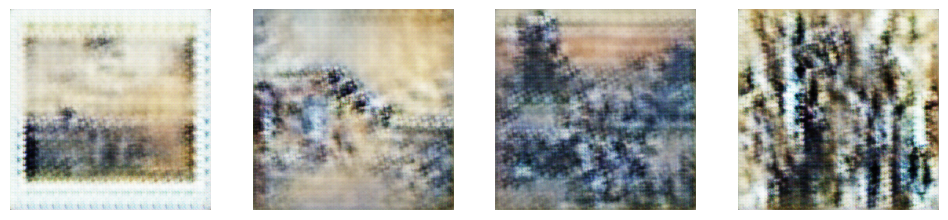

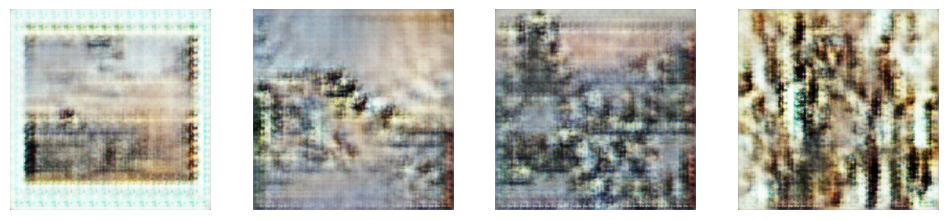

In [21]:
EPOCHS = 60
for epoch in range(EPOCHS):
    for photo, monet in tf.data.Dataset.zip((photo_image_dataset, monet_image_dataset)):
        train_step(photo, monet, generator_g, generator_f, discriminator_x, discriminator_y, 
                   generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer, discriminator_y_optimizer)
    # Save generated images to visualize progress
    if epoch % 10 == 0 or epoch == EPOCHS - 1:  # Visualize and save images every 10 epochs
        generate_and_save_images(generator_g, epoch, sample_photos[:SAMPLES_FOR_VISUALIZE])
        generator_g.save('generator_g_model_{}.h5'.format(epoch))

In [22]:
generator_g = tf.keras.models.load_model('generator_g_model_79.h5')

In [23]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    image = tf.expand_dims(image, 0)  # Add batch dimension
    return image

In [24]:
photo_directory = 'gan-getting-started/photo_jpg'
output_directory = 'gan-getting-started/converted'
os.makedirs(output_directory, exist_ok=True)

for filename in os.listdir(photo_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(photo_directory, filename)
        input_image = preprocess_image(image_path)
        transformed_image = generator_g.predict(input_image, verbose=0)
        transformed_image = (transformed_image + 1) * 127.5  # Denormalize to [0, 255]
        transformed_image = tf.squeeze(transformed_image).numpy().astype(np.uint8)  # Remove batch dimension and convert to uint8

        # Save the transformed image
        output_path = os.path.join(output_directory, 'monet_' + filename)
        tf.keras.preprocessing.image.save_img(output_path, transformed_image)

***
## See the result by Side-by-Side Plot
I can see somehow input is converted, but there are two major difficulties:

1. Image intensity is somehow inverted.
2. Output is not enought smooth. Some artifacts remainms...

In [25]:
photo_paths = glob.glob("gan-getting-started/photo_jpg"+ "/*.jpg")
output_paths = glob.glob("gan-getting-started/converted"+ "/*.jpg")

def show_side_by_side(photo_paths, output_paths, idx):
    path_photo = photo_paths[idx]
    path_output = output_paths[idx]

    p = cv2.cvtColor(cv2.imread(path_photo), cv2.COLOR_BGR2RGB)
    o = cv2.cvtColor(cv2.imread(path_output), cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(4, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(p)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(o)
    plt.axis('off')
    plt.show()

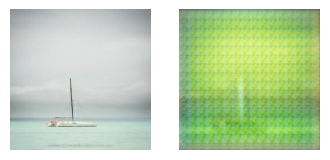

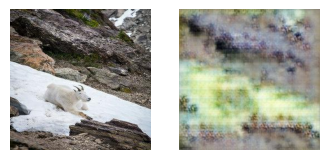

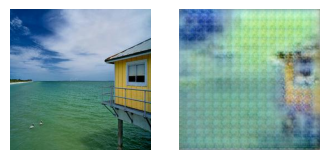

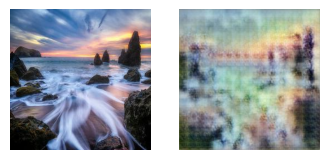

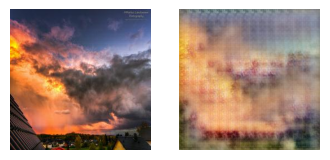

In [26]:
show_side_by_side(photo_paths, output_paths, 10)
show_side_by_side(photo_paths, output_paths, 120)
show_side_by_side(photo_paths, output_paths, 150)
show_side_by_side(photo_paths, output_paths, 290)
show_side_by_side(photo_paths, output_paths, 400)

***
## Conclusion
I could see something is changing, but to be honest, the output is nothing like monet painting...